<a href="https://colab.research.google.com/github/Renshui-MC/Physics-based-deep-learning/blob/main/Burgers%20Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Model**

##Burgers' equation (1D)

$$\frac{\partial u}{\partial t}+u \frac{\partial u}{\partial x}=\nu \frac{\partial^2 u}{\partial x^2}$$

###Step one: import `phiflow` library


In [4]:
!pip install --upgrade --quiet phiflow==2.2
from phi.flow import *

from phi import __version__
print("Using phiflow version: {}".format(phi.__version__))

     |████████████████████████████████| 266 kB 4.2 MB/s 
Using phiflow version: 2.2.0


## Initialization

To numerically solve **Burgers' equation**, we need discretized version of the PDE and specify its initial conditions:

+ In the spatial domain $\Omega$ for $[1, -1]$, we use $N = 128$ cells and $time = 32$. Therefore, time step $\Delta t = 1/32$. 
+ viscosity of $\nu = 0.01/\pi$
+ initial condition/state of $u = -\sin(\pi x)$

`np.asarray` converts input (`sin(\pi x)`) into an array.
`math.tensor` converts an array into a `phiflow` tensor     

In [56]:
import numpy as np

N = 128
dx = 2./N
steps = 32
dt = 1./steps
nu = 0.01/(N*np.pi)

# initialization of velocities, cell centers of a CenteredGrid have DX/2 offsets for linspace()
INITIAL_NUMPY = np.asarray( [-np.sin(np.pi * x) for x in np.linspace(-1+dx/2,1-dx/2,N)] ) # 1D numpy array

INITIAL = math.tensor(INITIAL_NUMPY, spatial('x') ) # convert to phiflow tensor that has a spatial dimension 'x'


Generate mesh (`CenteredGrid`) and set boundary conditions (`extrapolation.PERIODIC`). 

In [8]:
velocity = CenteredGrid(INITIAL, extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1)))
vt = advect.semi_lagrangian(velocity, velocity, dt)
#velocity = CenteredGrid(lambda x: -math.sin(np.pi * x), extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1)))
#velocity = CenteredGrid(Noise(), extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1))) # random init

print("Velocity tensor shape: "   + format( velocity.shape )) # == velocity.values.shape
print("Velocity tensor type: "    + format( type(velocity.values) ))
print("Velocity tensor entries 10 to 14: " + format( velocity.values.numpy('x')[10:15] ))

Velocity tensor shape: (xˢ=128)
Velocity tensor type: <class 'phi.math._tensors.CollapsedTensor'>
Velocity tensor entries 10 to 14: [0.4928982  0.53499764 0.57580817 0.6152316  0.65317285]


Run simulations to solve the PDE above. `for` loop is for **time advancement**. At every time step (`i`), `u` is updated at every time step within the **full spatial domain ($128 cells$)** (1D for this particular case). First solves the `diffusion` term and then use the solution of `u` to solve the `advection` term.

+ $\nu\partial^{2} u/\partial x^{2} = 0$
+ $\partial u/\partial t + u\partial u/\partial x = 0$

Eventually, an array of `v2` that contains the full solution (at $128$ cells) at every time instant is created. 

In [41]:
velocities = [velocity]
age = 0.
for i in range(steps):
    v1 = diffuse.explicit(velocities[-1], nu, dt) #using central differencing scheme to solve the diffusion term for the full domain 
    v2 = advect.semi_lagrangian(v1, v1, dt) #using first order approximation to solve the advection term for the full domain
    age += dt #update time
    velocities.append(v2) #update the velocity matrix

print("New velocity content at t={}: {}".format( age, velocities[-1].values.numpy('x,vector')[0:5] ))

New velocity content at t=1.0: [[0.0057228 ]
 [0.01716715]
 [0.02861034]
 [0.040052  ]
 [0.05149214]]


Visualization at several time instants: $0, 0.3125, 0.625, 1$. `lw` represents **line width**. `len(vels[ 0].flatten())` represents number of points, which is $128$ in the 1D case. `[-1]` means last entry of an array.

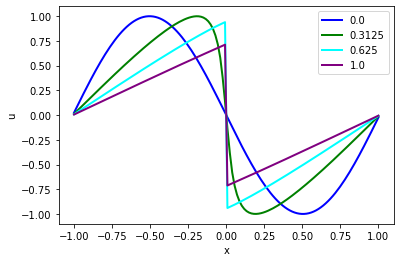

In [89]:
# get "velocity.values" from each phiflow state with a channel dimensions, i.e. "vector"
vels = [v.values.numpy('x,vector') for v in velocities] # gives a list of 2D arrays 
#print(velocities[32].values.numpy('x,vector')) #u solution at the last time step velocities[-1 or 32]
import pylab



fig = pylab.figure().gca()
fig.plot(np.linspace(-1,1,len(vels[ 0].flatten())), vels[ 0].flatten(), lw=2, color='blue',  label=str(0*dt))
fig.plot(np.linspace(-1,1,len(vels[10].flatten())), vels[10].flatten(), lw=2, color='green', label=str(10*dt))
fig.plot(np.linspace(-1,1,len(vels[20].flatten())), vels[20].flatten(), lw=2, color='cyan',  label=str(20*dt))
fig.plot(np.linspace(-1,1,len(vels[32].flatten())), vels[32].flatten(), lw=2, color='purple',label=str(32*dt))
pylab.xlabel('x'); pylab.ylabel('u'); pylab.legend()
print("The velocity solution at the last time step t={} and u={}".format(32*dt, velocities[-1].values.numpy('x,vector')[0:5]) )


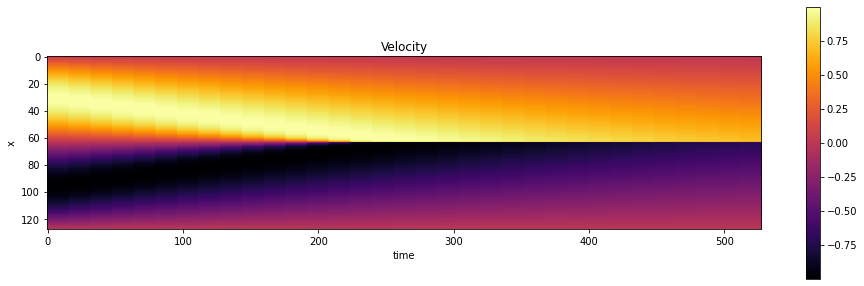

In [12]:
def show_state(a, title):
    # we only have 33 time steps, blow up by a factor of 2^4 to make it easier to see
    # (could also be done with more evaluations of network)
    a=np.expand_dims(a, axis=2)
    for i in range(4):
        a = np.concatenate( [a,a] , axis=2)

    a = np.reshape( a, [a.shape[0],a.shape[1]*a.shape[2]] )
    #print("Resulting image size" +format(a.shape))

    fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='inferno')
    pylab.colorbar(im) ; pylab.xlabel('time'); pylab.ylabel('x'); pylab.title(title)
        
vels_img = np.asarray( np.concatenate(vels, axis=-1), dtype=np.float32 ) 

# save for comparison with reconstructions later on
import os; os.makedirs("./temp",exist_ok=True)
np.savez_compressed("./temp/burgers-groundtruth-solution.npz", np.reshape(vels_img,[N,steps+1])) # remove batch & channel dimension

show_state(vels_img, "Velocity")